<br><h1> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="120" width="400" align="Center" /><br>

# MIIIA Advanced Models: Ejercicio 8 Random Forest - 29 Jun 2020

                     Names                 User        Code
           - Alexander Camargo García   a.camargo733   200911325
           - Jaime Orjuela Viracachá    j.orjuelav     201924252
           - Jairo Pedraza Corredor     j.pedraza      201924260
           - Elquin Huertas Ramírez     e.huertas      201920061

## Car Price Prediction

Predict if the price of a car is low or high

In [21]:
y_pred_mean=y_pred.mean(axis=1)

In [1]:
%matplotlib inline
import pandas as pd
import math
data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [5]:
import pandas as pd
import numpy as np
from sklearn import metrics

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [11]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted  

In [12]:
Prediction1=tree_predict(X_test, tree)
Prediction1=pd.DataFrame(Prediction1)
Prediction1.columns = ['Prediction']
Prediction1.head()

,Prediction
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,Prediction1)

0.8433179723502304

In [14]:
metrics.f1_score(Prediction1, y_test.values), metrics.accuracy_score(Prediction1, y_test.values)

(0.8667711598746082, 0.8433179723502304)

* El accuracy obtenido en la muestra de test para un modelo usando un sólo árbol de decisión es 0.8433
* El F1-Score obtenido en la muestra de test para un modelo usando un sólo árbol de decisión es 0.8667


# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [15]:
import math
from random import randrange

In [16]:
n_samples=X_train.shape[0]
n_B=10
samples=[np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B+1)]
len(samples)

10

In [17]:
y_train_df=pd.DataFrame(y_train)
y_train_df.head()

,HighPrice
475678,0
23079,1
291651,1
277196,0
14923,1


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

tree_cla=DecisionTreeClassifier(max_depth=None, random_state=1)
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [19]:
for i in range(10):
    X1=X_train.iloc[samples[i], :]
    y1=y_train_df.iloc[samples[i], :]
    tree_cla.fit(X1, y1)
    y_pred[i] = tree_cla.predict(X_test)

In [20]:
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
332784,0,1,0,0,0,0,1,0,1,0
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [21]:
y_pred_mean=y_pred.mean(axis=1)

In [24]:
y_pred_t = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)
print('accuracy', metrics.accuracy_score(y_test,y_pred_t))

accuracy 0.8488479262672811


El accuracy obtenido haciendo bagging sobre los 10 arboles de clasificación es de 0.8433, el cual mejora un poco comparado con el arbol individual

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [29]:
#realizamos una prueba de la partición aleatoria de X antes de incluirla a la función del árbol
b=list(np.random.choice(range(X.shape[1]),3,replace=False))
X_split=X.iloc[:,b]
X_split.head()

,M_Camry,M_CamryLE,Year,M_CamryL,M_CamryBase
15,0,1,2016,0,0
47,0,1,2015,0,0
85,0,0,2012,0,0
141,0,0,2017,0,0
226,0,0,2014,0,0


Ahora insertamos esta selección de variables aleatorias en la función del DecisionTree y definimos el parámetro adicional max_feature como el tamaño de la submuestra de las variables. 

In [56]:
def tree_grow_rf(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=X.shape[1]):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
   
    #seleccion aleatoria de variables previo al split en cada nodo
    max_features=int(max_features)
    b=list(np.random.choice(range(X.shape[1]),max_features,replace=False))
    X_split=X.iloc[:,b]
    
    # Calculate the best split
    j, split, gain = best_split(X_split, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    j=b[j]
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [57]:
tree_rf=tree_grow_rf(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=int(round(len(X.columns)**0.5,0)))

In [58]:
tree_rf

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [7, 1.0],
 'n_samples': 8810,
 'gain': 0.047397628956509674,
 'sl': {'y_pred': 0,
  'y_prob': 0.4575247162211644,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5460,
  'gain': 0.25186871744791184,
  'sl': {'y_pred': 0,
   'y_prob': 0.07056936647955092,
   'level': 2,
   'split': [1, 47197.81818181818],
   'n_samples': 2492,
   'gain': 0.02076267210948006,
   'sl': {'y_pred': 0,
    'y_prob': 0.3930131004366812,
    'level': 3,
    'split': -1,
    'n_samples': 227,
    'gain': 0.07664572956019833},
   'sr': {'y_pred': 0,
    'y_prob': 0.038376709307454786,
    'level': 3,
    'split': -1,
    'n_samples': 2265,
    'gain': 0.00527879134265008}},
  'sr': {'y_pred': 1,
   'y_prob': 0.7824915824915825,
   'level': 2,
   'split': [1, 48395.0],
   'n_samples': 2968,
   'gain': 0.05144712762454906,
   'sl': {'y_pred': 1,
    'y_prob': 0.8580246913580247,
    'level': 3,
    'split': -1,
    'n_samples': 2428,
    'gai

In [59]:
y_pred_rf= tree_predict(X_test, tree_rf)
print('accuracy', metrics.accuracy_score(y_test,y_pred_rf))

accuracy 0.8608294930875576


Haciendo el mismo arbol de clasificación, pero haciendo la selección de variables para el split, el accuracy mejora 2pp aprox, llegando a niveles de 0.86

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [60]:
import math

In [67]:
n_samples=X_train.shape[0]
n_B=10
samples=[np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B+1)]
len(samples)

10

In [71]:
np.log(X_train.shape[1])

2.1972245773362196

In [84]:
y_pred_rrf= pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [80]:
#ajustamos el árbol para el bagging con el max_feature del punto 8.3, pero ahora ajustando el parámetro a log(p)

for i in range(10):
    X1=X_train.iloc[samples[i], :]
    y1=y_train_df.iloc[samples[i], :]
    tree_rrf=tree_grow_rf(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=np.log(X.shape[1]))
    y_pred_rrf[i] = tree_predict(X_test,tree_rrf)

In [81]:
y_pred_rrf.head()

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
y_pred_rrf2 = (y_pred_rrf.sum(axis=1) >= (n_B / 2)).astype(np.int)
print('accuracy Bagging RF_log', metrics.accuracy_score(y_test,y_pred_rrf2))

accuracy Bagging RF_log 0.8539170506912442


Utilizando el algoritmo de bagging bajo el Decisiontree con selección aleatoria de varables en el split mejora un poco el performances comparado con el bagging del 8.2, ahora el accuracy del modelo es de 0.853, sin embargo sigue siendo mejor el modelo de bagging utilizando la raiz cuadrada como parámetro de selección de variables, aunque los accuracys de estos dos modelos son similares.

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


### Fitting a Random Forest 

In [30]:
clf = RandomForestClassifier(random_state=8, n_jobs=-1)
predRF=clf.fit(X_train, y_train)
PredictionRF=predRF.predict(X_test)

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [31]:
accuracy_score(y_test,PredictionRF)

0.8394009216589862

* El accuracy para la muestra de prueba usando el modelo de Random Forest es de 0.8394, ligeramente menor al obtenido con el árbol de decisión.

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

### Tunning max_depth

In [39]:
max_depth_range=range(1,15,1)
# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in max_depth_range:
    clf = RandomForestClassifier(max_depth=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

Text(0, 0.5, 'Accuracy')

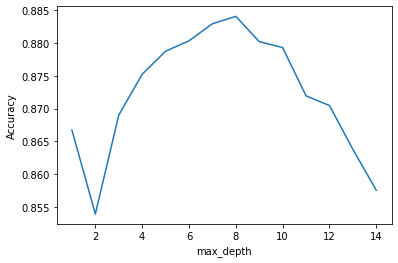

In [40]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

* Con un valor de 8 en el máximo de profundidad del árbol, se optimiza el accuracy

### Tuning n_estimators


In [41]:
estimator_range = range(1, 20, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

Text(0, 0.5, 'Accuracy')

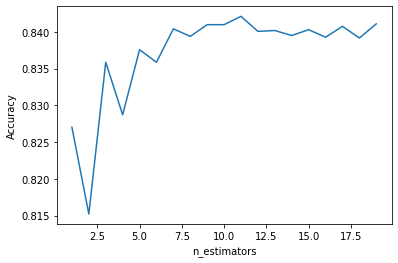

In [42]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

* Se observan 12 estimadores como el número que optimiza el accuracy

### Tuning max_features

In [43]:
feature_cols = X_train.shape[1]
feature_cols
# list of values to try for max_features
feature_range = range(1, feature_cols+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=12, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

Text(0, 0.5, 'Accuracy')

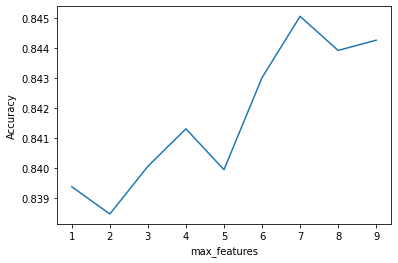

In [44]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

* Con 7 atributos, el accuracy se optimiza

In [46]:
clf = RandomForestClassifier(random_state=8, n_jobs=-1, max_depth=8, n_estimators=12, max_features=7)
predRF2=clf.fit(X_train, y_train)
PredictionRF2=predRF2.predict(X_test)
accuracy_score(y_test,PredictionRF2)

C:\Users\elqui\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8799539170506913

* El accuracy en la muestra de prueba para el Random Forest que optimizó algunos parámetros fue de 0.8799. Con esta optimización el nivel de predicción es mucho mejor que el modelo Random Forest sin optimizar y el modelo de un solo árbol de decisión.

#### Adicionalmente se hizo una optimización de otros parámetros del modelo de Random Forest para ver los resultados que se obtienen 

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [48]:
RF_model_0 = RandomForestClassifier(random_state = 8) # Configura el random_stated para que el trabajo sea replicable

In [70]:
n_estimators = range(1,20,1) #Cantidad de arboles en el bosque
max_features = range(1, feature_cols+1,1) # Cantidad de features donde se realiza la bifurcacion del arbol
max_depth = range(1,20,1) # Maxima profundidad en cada arbol del bosque
min_samples_split = [2,3,4,5,8, 10, 15]
min_samples_leaf = [1, 2, 4,6,8,10]
bootstrap = [True, False] # Muestreo con y sin reemplazo

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [71]:
rfc = RandomForestClassifier(random_state=8) # Modelo a optimizar
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklear

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [72]:
print("Los mejores Parametros encontrados son:")
print(random_search.best_params_)
print("")
print("La media de accuracy del modelo en trainning con dichos parámetros es:")
print(random_search.best_score_)

Los mejores Parametros encontrados son:
{'n_estimators': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 8, 'bootstrap': True}

La media de accuracy del modelo en trainning con dichos parámetros es:
0.8854710556186152


In [73]:
clf = RandomForestClassifier(random_state=8, n_jobs=-1, max_depth=8, n_estimators=11, max_features=8, min_samples_split=3,
                             min_samples_leaf=4)
predRF3=clf.fit(X_train, y_train)
PredictionRF3=predRF3.predict(X_test)
accuracy_score(y_test,PredictionRF3)



C:\Users\elqui\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8799539170506913

* El accuracy obtenido es el mismo que bajo la optimización anterior del modelo Random Forest, los demás áramétros ajustados no generaron mayor ganancia en el nivel predictivo del modelo

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [74]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [75]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.8989412897016361, 0.8790322580645161)

* El accuracy en la muestra de prueba para el modelo XGBoost es de 0.879, ligeramente menor al obtenido con Random Forest optimizado.

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

- *learning_rate*: Es usado para controlar el peso de nuevos árboles que son adicionados al modelo, de esta manera se ajusta la tasa de aprendizaje del modelo por la inclusión de estos nuevos árboles.


C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


Best: 0.883201 using {'learning_rate': 0.01}
0.879909 (0.003842) with: {'learning_rate': 0.0001}
0.882633 (0.005018) with: {'learning_rate': 0.001}
0.883201 (0.005794) with: {'learning_rate': 0.01}
0.882293 (0.007054) with: {'learning_rate': 0.1}
0.880023 (0.006007) with: {'learning_rate': 0.2}
0.875596 (0.005155) with: {'learning_rate': 0.3}


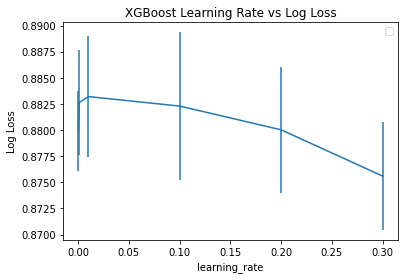

In [76]:
# Se analizan diferentes valores de Learning Rates.

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
xgb = XGBClassifier(random_state=8)
param_grid = dict(learning_rate=learning_rate)
grid_search = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid)
# Fit the grid search to the data
clf=grid_search.fit(X_train, y_train)

# Summary result
print("Best: %f using %s" % (clf.best_score_,clf.best_params_))
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']
params=clf.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print("%f (%f) with: %r" %(mean, stdev, param))

#plot
plt.legend()
plt.errorbar(learning_rate, means, yerr=stds)
plt. title("XGBoost Learning Rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('Learning_rate.png')



- *Gamma*: Sirve cuando un nodo es abierto solo cuando el resultado del nodo da una reducción positiva en la función de ganancia. Gamma especifica la reducción de pérdida mínima requerida para hacer una apertura del árbol. 

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


Best: 0.884449 using {'gamma': 3}
0.875709 (0.006365) with: {'gamma': 0.1}
0.875596 (0.005155) with: {'gamma': 0}
0.884109 (0.003923) with: {'gamma': 5}
0.881044 (0.004327) with: {'gamma': 1}
0.883995 (0.006723) with: {'gamma': 2}
0.884449 (0.005452) with: {'gamma': 3}
0.884222 (0.003386) with: {'gamma': 4}
0.884109 (0.003923) with: {'gamma': 5}


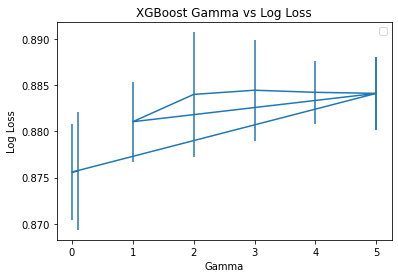

In [77]:
# Se analizan diferentes valores de Gamma.

gamma = [0.1, 0,5, 1, 2, 3, 4, 5]
xgb = XGBClassifier(random_state=8)
param_grid = dict(gamma=gamma)
grid_search = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid)
# Fit the grid search to the data
clf=grid_search.fit(X_train, y_train)

# Summary result
print("Best: %f using %s" % (clf.best_score_,clf.best_params_))
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']
params=clf.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print("%f (%f) with: %r" %(mean, stdev, param))

#plot
plt.legend()
plt.errorbar(gamma, means, yerr=stds)
plt. title("XGBoost Gamma vs Log Loss")
plt.xlabel('Gamma')
plt.ylabel('Log Loss')
plt.savefig('Gamma.png')

- *colsample_bytree*: Número de variables usadas por cada árbol. Con el fin de evitar que algunas variables tengan protagonismo en la predicción, se toma una muestra de dichas variables. Se recomienda analizar valores entre 0.3 y 0.8 si se tienen muchas columnas o 0.8 a 1 si se tienen pocas.

C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\elqui\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


Best: 0.878207 using {'colsample_bytree': 0.9}
0.878093 (0.003292) with: {'colsample_bytree': 0.8}
0.878093 (0.003292) with: {'colsample_bytree': 0.85}
0.878207 (0.007479) with: {'colsample_bytree': 0.9}
0.878207 (0.007479) with: {'colsample_bytree': 0.95}
0.875596 (0.005155) with: {'colsample_bytree': 1}


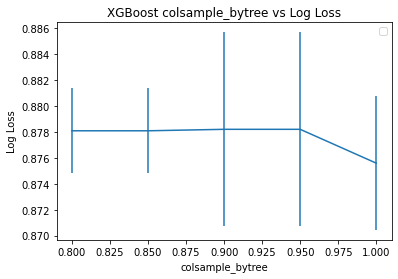

In [78]:
# Se analizan diferentes valores de colsample_bytree.

colsample_bytree = [0.8, 0.85, 0.9, 0.95, 1]
xgb = XGBClassifier(random_state=8)
param_grid = dict(colsample_bytree=colsample_bytree)
grid_search = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid)
# Fit the grid search to the data
clf=grid_search.fit(X_train, y_train)

# Summary result
print("Best: %f using %s" % (clf.best_score_,clf.best_params_))
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']
params=clf.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print("%f (%f) with: %r" %(mean, stdev, param))

#plot
plt.legend()
plt.errorbar(colsample_bytree, means, yerr=stds)
plt. title("XGBoost colsample_bytree vs Log Loss")
plt.xlabel('colsample_bytree')
plt.ylabel('Log Loss')
plt.savefig('colsample_bytree.png')

In [79]:
# Se crea el conjunto de parametros basados en los resultados anteriores 

xgb = XGBClassifier(random_state=8,colsample_bytree=0.9,gamma=3,learning_rate=0.01)
# Fit the grid search to the data
clf=xgb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)



(0.9020726373835329, 0.881336405529954)

* El accuracy obtenido para la muestra de prueba utilizando el modelo XGBoots optimizado fue de 0.8813, el cual fue el mayor de todos los modelos analizados. Se evidencia que este modelo genera niveles de clasificación mucho mayores que los obtenidos bajo otros modelos. 